# Neural classifier for the detection of glaucoma

### Lorenzo Venieri

In [2]:
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt
import random as rd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet50

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import seaborn as sns

%matplotlib inline

In [3]:
labels = {'normal': 0, 'abnormal': 1}
num_to_labels = {0: 'normal', 1: 'abnormal'}

def load_fold(fold_dir):
    fold = {}
    for partition in ['test', 'train', 'valid' ]:
        fold[partition] = []
        for y in ['abnormal', 'normal']:
            imgs_dir = os.path.join(fold_dir, partition, y)
            for img_name in os.listdir(imgs_dir):
                file_name = os.path.join(imgs_dir, img_name)
                #if file_name[:-4]
                img = cv2.imread(file_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                fold[partition].append({'X': img, 'y': labels[y]})
                        
    return fold

In [4]:
folds_dir = '../input/practica-dl-uoc-2022/practica_DL_UOC_2022'
folds = []
for n in range(10):
    fold_dir = os.path.join(folds_dir, f'Fold{n}')
    folds.append(load_fold(fold_dir))

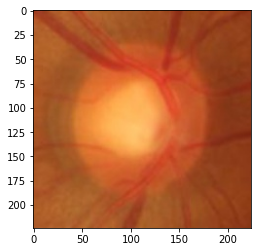

In [7]:
plt.imshow(folds[0]['train'][0]['X']) #see an example of the data

In [5]:
def X_y_from_fold(partition, folders_numbers=[i for i in range(10)]):
    X = []
    y = []
    for n in folders_numbers:
        X.append([img['X'] for img in folds[n][partition]])
        y.append([img['y'] for img in folds[n][partition]])
    X = np.array(X)
    y = np.array(y)
    y = to_categorical(y)
    return X, y
                      

# X, y sets from all Folds
X_train, y_train = X_y_from_fold(partition = 'train')
X_test, y_test = X_y_from_fold(partition = 'test')
X_valid, y_valid = X_y_from_fold(partition = 'valid')

# 1) Exploratory anaylsis of data

In [15]:
print('Each fold in the set X_train contains {} images of size {}x{}, with {} color channels.'.format(
    X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4]
))
print('Each fold in the set y_train contains {} instances with {} labels each.'.format(
      y_train.shape[1], y_train.shape[2]
))
print('Each fold in the set X_test contains {} images of size {}x{}, with {} color channels.'.format(
    X_test.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[4]
))
print('Each fold in the set y_test contains {} instances with {} labels each.'.format(
      y_test.shape[1], y_test.shape[2]
))
print('Each fold in the set X_valid contains {} images of size {}x{}, with {} color channels.'.format(
    X_valid.shape[1], X_valid.shape[2], X_valid.shape[3], X_valid.shape[4]
))
print('Each fold in the set y_valid contains {} instances with {} labels each.'.format(
      y_valid.shape[1], y_valid.shape[2]
))

Each fold in the set X_train contains 1379 images of size 224x224, with 3 color channels.
Each fold in the set y_train contains 1379 instances with 2 labels each.
Each fold in the set X_test contains 174 images of size 224x224, with 3 color channels.
Each fold in the set y_test contains 174 instances with 2 labels each.
Each fold in the set X_valid contains 154 images of size 224x224, with 3 color channels.
Each fold in the set y_valid contains 154 instances with 2 labels each.


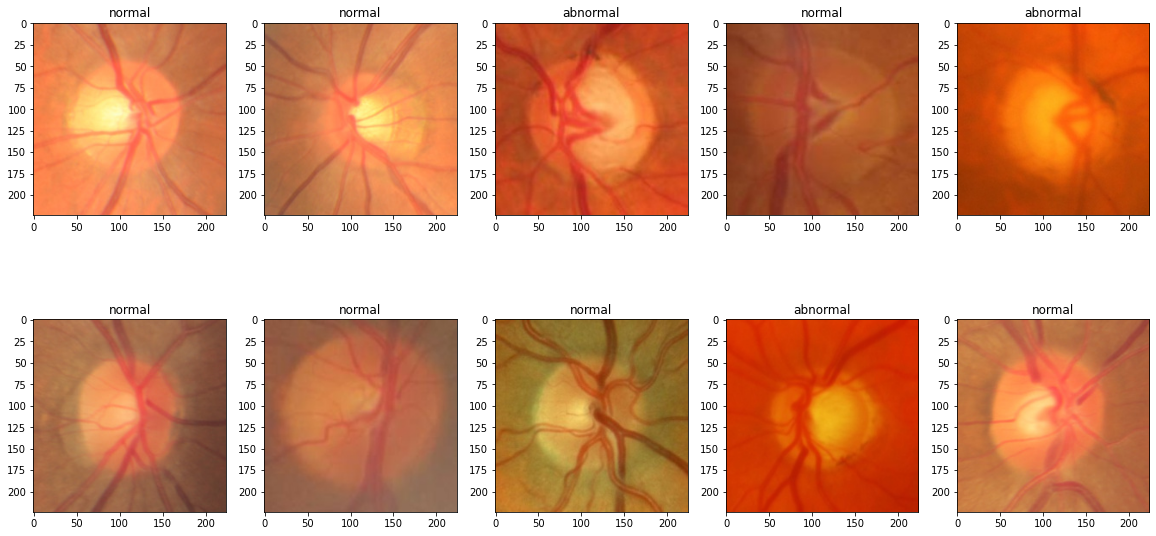

In [16]:
#visualize 10 images with their label

def imshow(img, title=None):
  if title is not None:
    plt.title(title)
  plt.imshow(img)

plt.figure(figsize=(20,10))
for i,image in enumerate(rd.sample(folds[0]['train'],10)):
  plt.subplot(2,5,i+1)
  imshow(image['X'],num_to_labels[image['y']] )

In [17]:
#let's see how many train, test and validation instances are in each fold
for n in range(10):
    print(f'fold{n}, #train instances:', len(folds[n]['train']))
    print(f'fold{n}, #test instances:', len(folds[n]['test']))
    print(f'fold{n}, #validation instances:', len(folds[n]['valid']))
    print('\n')

fold0, #train instances: 1379
fold0, #test instances: 174
fold0, #validation instances: 154


fold1, #train instances: 1379
fold1, #test instances: 174
fold1, #validation instances: 154


fold2, #train instances: 1379
fold2, #test instances: 174
fold2, #validation instances: 154


fold3, #train instances: 1379
fold3, #test instances: 174
fold3, #validation instances: 154


fold4, #train instances: 1379
fold4, #test instances: 174
fold4, #validation instances: 154


fold5, #train instances: 1379
fold5, #test instances: 174
fold5, #validation instances: 154


fold6, #train instances: 1379
fold6, #test instances: 174
fold6, #validation instances: 154


fold7, #train instances: 1379
fold7, #test instances: 174
fold7, #validation instances: 154


fold8, #train instances: 1379
fold8, #test instances: 174
fold8, #validation instances: 154


fold9, #train instances: 1379
fold9, #test instances: 174
fold9, #validation instances: 154




Every fold has the same number of train/test/validation instances.

In [18]:
#let's see how many abnormal and normal instances are in each fold
def count_labels(fold):
    abnormal = 0
    normal = 0
    for k in fold.keys():
        for inst in fold[k]:
            if inst['y'] == 1:
                abnormal +=1
            else:
                normal +=1
    #print(f'in this fold there are {abnormal} abnormal instances and {normal} normal instances')
    return normal, abnormal       
        
for n, fold in enumerate(folds):
    normal, abn = count_labels(fold)
    print(f'In fold{n} there are {abn} abnormal instances and {normal} normal instances')
    

In fold0 there are 788 abnormal instances and 919 normal instances
In fold1 there are 788 abnormal instances and 919 normal instances
In fold2 there are 788 abnormal instances and 919 normal instances
In fold3 there are 788 abnormal instances and 919 normal instances
In fold4 there are 788 abnormal instances and 919 normal instances
In fold5 there are 788 abnormal instances and 919 normal instances
In fold6 there are 788 abnormal instances and 919 normal instances
In fold7 there are 788 abnormal instances and 919 normal instances
In fold8 there are 788 abnormal instances and 919 normal instances
In fold9 there are 788 abnormal instances and 919 normal instances


In every fold the ratio between abnormal and normal instances is constant: 788/919. In fact, each fold contains the same 1707 images partitioned in different ways.

In the train sets there are 7452 normal instances and 6338 abnormal instances.
In the test sets there are 919 normal instances and 821 abnormal instances.
In the validation sets there are 819 normal instances and 721 abnormal instances.


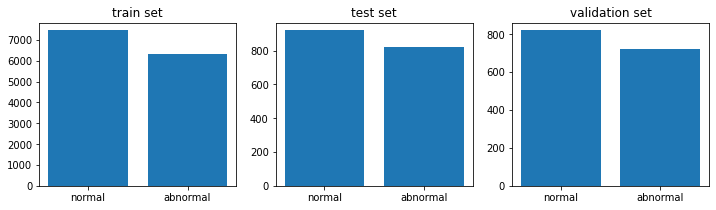

In [19]:
#bar plots of the number of abnormal and normal instances in all the folds combined, divided by partition (train, test, valid)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title('train set')
heights, _ = np.histogram(np.argmax(y_train.reshape(-1,2), axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the train sets there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

plt.subplot(1,3,2)
plt.title('test set')
heights, _ = np.histogram(np.argmax(y_test.reshape(-1,2), axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the test sets there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

plt.subplot(1,3,3)
plt.title('validation set')
heights, _ = np.histogram(np.argmax(y_valid.reshape(-1,2), axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the validation sets there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

The classes are just slightly inbalanced: there are about 15% more normal instances than abnormal ones.

Distribution of normal/abnormal instances in Fold0:
In the train set there are 754 normal instances and 625 abnormal instances.
In the test set there are 82 normal instances and 92 abnormal instances.
In the validation set there are 83 normal instances and 71 abnormal instances.


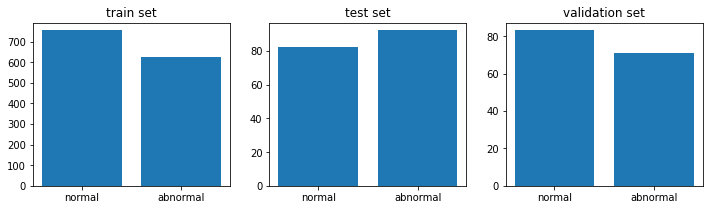

In [20]:
#let's see the distribution in Fold0

print('Distribution of normal/abnormal instances in Fold0:')

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title('train set')
heights, _ = np.histogram(np.argmax(y_train[0], axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the train set there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

plt.subplot(1,3,2)
plt.title('test set')
heights, _ = np.histogram(np.argmax(y_test[0], axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the test set there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

plt.subplot(1,3,3)
plt.title('validation set')
heights, _ = np.histogram(np.argmax(y_valid[0], axis=1), bins=2)
plt.bar(['normal','abnormal'], heights)
print(f'In the validation set there are {heights[0]} normal instances and {heights[1]} abnormal instances.')

# 2) Train of a neural network on just one fold

In this first part we'll train the network just on fold0. This will permit us to obtain preliminary conclusions with in reasonable time, before doing the full training (with cross validation). We'll propose 5 different models:
- The first 3 configuartions are built over an EfficientNet B0 feature extractor, pretrained with ImageNet weigths, adding a classification head composed by a GlobalAveragePooling2D layer, a BatchNormalization layer, a Dropout layer (0.2) and at the end a fully connected layer.
    - The 1st model is built training just the classification head, freezing all others layers.
    - The 2nd model is trained starting from the weights of the first model, unfreezing the last 20 layers (BatchNorm layers excluded).
    - The 3rd model is trained starting from the weights of the second model, unfreezing all the layers (BatchNorm layers exluded).
- The 4th model is built on a ResNet50 feature extractor, pretrained on the ImageNet dataset. On top of the feature extractor, that is set as untrainable during the training, is built a classification head that consists of 4 layers, analogously to what was done in model 1: GlobalAveragePolling2D, BatchNormalization, dropout (0.2), and at the end a FC layer.
- The 5th is built on a Xception feature extractor, pretrained on the ImageNet dataset. On top of the feature extractor was built a classification head that consists of 4 layers, analogously to what was done in model 1 and 4.

For each model the best performing epoch was find using early stopping. We also tried different starting learning rates for the Adam optimizer. 

In [1]:
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

#I use a custom function to calculate the F1 score

def custom_f1(y_true, y_pred):    
    #True positivies, false positives and false negatives are computed globally. It is analogous to tfa.metrics.F1Score with average = 'micro'
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_class1(y_true, y_pred): #F1 score for class 1
    f1 = tfa.metrics.F1Score(num_classes=2)
    return f1(y_true, y_pred)[1]

def plot_hist(hist):
    plt.plot(hist.history["custom_f1"])
    plt.plot(hist.history["val_custom_f1"])
    plt.title("model f1-score")
    plt.ylabel("f1-score")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


### Model 1

We don't do standardization nor normalization: in EfficientNet documentation is written that "This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model."

We import EfficientNetB0 that works with images of resolution = 224.


In [8]:
num_classes = 2
IMG_SIZE = 224
learning_rates = [0.0001, 0.001, 0.01]
epochs = 30

def build_model1(lr):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="Model1")
    optimizer = tf.keras.optimizers.Adam(learning_rate= lr)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[custom_f1]
    )
    return model

from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_custom_f1', patience = 5, mode = 'max', restore_best_weights=True)

#Function to compute several models changing learning rates
def models(model_builder, learning_rates, model_number):
  histories=[]
  for lr in learning_rates:
    model=model_builder(lr)
    X_train_0, y_train_0 = shuffle(X_train[0], y_train[0]) #training data is ordered by label, it has to be shuffled
    history=model.fit(X_train_0, y_train_0, epochs = epochs, batch_size = 32 , validation_data=(X_valid[0], y_valid[0]), verbose=2, callbacks=[callback])
    histories.append(history)
    model.save(f'/kaggle/working/Model{model_number}_lr{lr}')
  return histories

In [ ]:
histories = models(build_model1, learning_rates, 1)

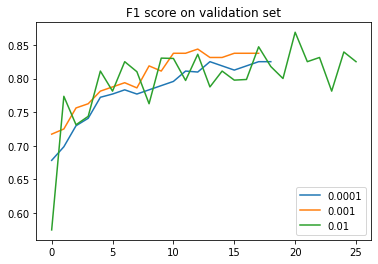

In [19]:
plt.figure()
plt.title('F1 score on validation set')
for lr in learning_rates:
  plt.plot(histories[learning_rates.index(lr)].history["val_custom_f1"], label=lr)
plt.legend()

The best performance on the validation set is reached by the model with lr = 0.01. (on epoch 21)

In [11]:
#performance of the model on the test set:

def performance_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    label_predicted=np.where(y_pred > 0.5, 1,0)

    print(classification_report(y_test, label_predicted ))

    label_pred_int = np.argmax(label_predicted,axis=1)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis = 1), label_pred_int);


In [33]:
#load Models

Model1_lr0001 = keras.models.load_model("Model1_lr0.001", custom_objects={"custom_f1": custom_f1})
Model1_lr00001 = keras.models.load_model("Model1_lr0.0001", custom_objects={"custom_f1": custom_f1})
Model1_lr001 = keras.models.load_model("Model1_lr0.01", custom_objects={"custom_f1": custom_f1})

lr =  0.0001
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        82
           1       0.90      0.66      0.76        92

   micro avg       0.78      0.78      0.78       174
   macro avg       0.80      0.79      0.78       174
weighted avg       0.81      0.78      0.78       174
 samples avg       0.78      0.78      0.78       174

lr =  0.001
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        82
           1       0.92      0.71      0.80        92

   micro avg       0.81      0.81      0.81       174
   macro avg       0.83      0.82      0.81       174
weighted avg       0.83      0.81      0.81       174
 samples avg       0.81      0.81      0.81       174

lr =  0.01
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        82
           1       0.84      0.76      0.80        92

   micro avg       0.80      0.80     

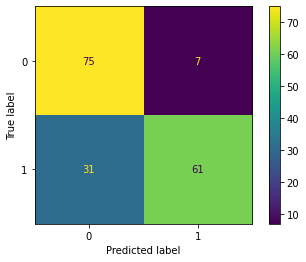

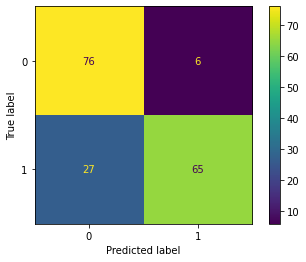

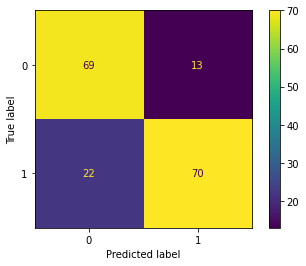

In [34]:
for model in [Model1_lr00001, Model1_lr0001, Model1_lr001]:
    print('lr = ', learning_rates[[Model1_lr00001, Model1_lr0001, Model1_lr001].index(model)])
    performance_test(model, X_test[0], y_test[0])

We need high F1-score and high recall on the abnormal set: since we want to spot glaucoma when is present, we need to minimize the amount of False Negatives for the abnormal class (1).  
The best performing model on the test set is the Model1_lr0.01, we use this one as a base to train the next model.

In [ ]:
Model1_lr001.summary()

### Model 2

In [44]:
def unfreeze_last_layers(model, lr):
    # We unfreeze the top 20 layers of the feature extractor + the classification head, leaving BatchNorm layers frozen
    for layer in model.layers[-24:]: #20 layers of the feature extractor + 4 layers of the classification head
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[custom_f1]
    )
    return model

def build_model2(lr):
    #we need to load the model each time the function is called, otherwise the next training
    # instance starts from the weights of the previous training instance
    model1 = keras.models.load_model("Model1_lr0.01", custom_objects={"custom_f1": custom_f1})
    model = unfreeze_last_layers(model1, lr)
    return model

In [ ]:
# the model has the last layers unfrozen
model2_test = build_model2(0.0001)
model2_test.summary()

In [ ]:
histories = models(build_model2, learning_rates, 2)

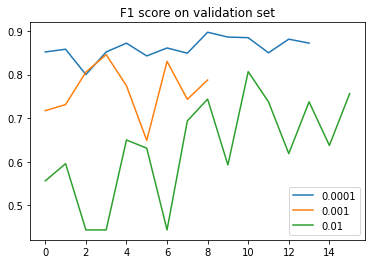

In [39]:
plt.figure()
plt.title('F1 score on validation set')
for lr in learning_rates:
  plt.plot(histories[learning_rates.index(lr)].history["val_custom_f1"], label=lr)
plt.legend()

The best performance on the validation set was reached by the model with lr = 0.0001 (on epoch 9).

In [40]:
#load Models

Model2_lr0001 = keras.models.load_model("Model2_lr0.001", custom_objects={"custom_f1": custom_f1})
Model2_lr00001 = keras.models.load_model("Model2_lr0.0001", custom_objects={"custom_f1": custom_f1})
Model2_lr001 = keras.models.load_model("Model2_lr0.01", custom_objects={"custom_f1": custom_f1})

lr =  0.0001
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        82
           1       0.84      0.89      0.86        92

   micro avg       0.85      0.85      0.85       174
   macro avg       0.85      0.85      0.85       174
weighted avg       0.85      0.85      0.85       174
 samples avg       0.85      0.85      0.85       174

lr =  0.001
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        82
           1       0.87      0.86      0.86        92

   micro avg       0.86      0.86      0.86       174
   macro avg       0.86      0.86      0.86       174
weighted avg       0.86      0.86      0.86       174
 samples avg       0.86      0.86      0.86       174

lr =  0.01
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        82
           1       0.85      0.78      0.81        92

   micro avg       0.81      0.81     

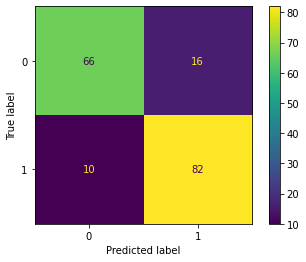

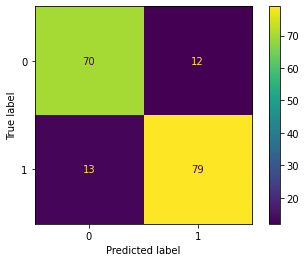

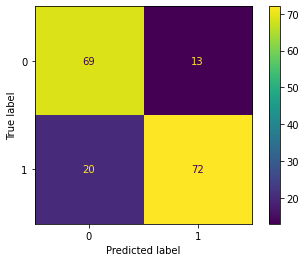

In [41]:
for model in [Model2_lr00001, Model2_lr0001, Model2_lr001]:
    print('lr = ', learning_rates[[Model2_lr00001, Model2_lr0001, Model2_lr001].index(model)])
    performance_test(model, X_test[0], y_test[0])

Although Model2_lr0.001 has the best overall performance, the recall of the Model2_lr0.0001 on the abnormal class is much better. At the expense of just 1% in f1-score, we have less false negative for the abnormal class. So we pick this Model to build Model3.

### Model 3

In [48]:
def unfreeze_model(model, lr):
    for layer in model.layers[:]: #unfreeze all layers
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[custom_f1]
    )
    return model

def build_model3(lr):
    model2 = keras.models.load_model("Model2_lr0.0001", custom_objects={"custom_f1": custom_f1})
    model = unfreeze_model(model2, lr)
    return model

In [ ]:
# The model is indeed unfreezed:
model3_test = build_model3(0.0001)
model3_test.summary()

In [45]:
#With bigger lrs the weight of the first pretrained layers are destroyed and gives bad results
learning_rates = [0.000001, 0.00001, 0.0001] 

In [ ]:
histories = models(build_model3, learning_rates, 3)

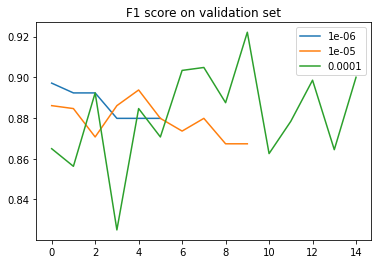

In [47]:
plt.figure()
plt.title('F1 score on validation set')
for lr in learning_rates:
  plt.plot(histories[learning_rates.index(lr)].history["val_custom_f1"], label=lr)
plt.legend()

The best performance on the validation set was reached by the model with lr = 0.0001 (on epoch 10).

In [48]:
#load Models

Model3_lr1e06 = keras.models.load_model("Model3_lr1e-06", custom_objects={"custom_f1": custom_f1})
Model3_lr1e05 = keras.models.load_model("Model3_lr1e-05", custom_objects={"custom_f1": custom_f1})
Model3_lr1e04 = keras.models.load_model("Model3_lr0.0001", custom_objects={"custom_f1": custom_f1})

lr =  1e-06
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        82
           1       0.90      0.86      0.88        92

   micro avg       0.87      0.87      0.87       174
   macro avg       0.87      0.87      0.87       174
weighted avg       0.87      0.87      0.87       174
 samples avg       0.87      0.87      0.87       174

lr =  1e-05
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        82
           1       0.96      0.79      0.87        92

   micro avg       0.87      0.87      0.87       174
   macro avg       0.88      0.88      0.87       174
weighted avg       0.89      0.87      0.87       174
 samples avg       0.87      0.87      0.87       174

lr =  0.0001
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        82
           1       0.88      0.92      0.90        92

   micro avg       0.89      0.89    

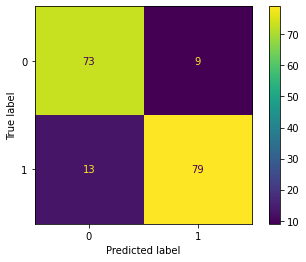

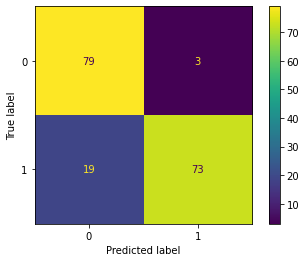

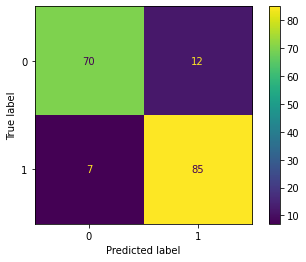

In [50]:
for model in [Model3_lr1e06 , Model3_lr1e05, Model3_lr1e04]:
    print('lr = ', learning_rates[[Model3_lr1e06 , Model3_lr1e05, Model3_lr1e04].index(model)])
    performance_test(model, X_test[0], y_test[0])

The best performing model on the test set is Model3_lr1e04, both for overall f1-score and for recall on the abnormal class.

In [ ]:
Model3_lr1e04.save("Model3_lr1e04")

In [ ]:
Model3 = tf.keras.models.load_model("../input/models2-3/Model3_lr0.0001", custom_objects={"custom_f1": custom_f1})
#I saved model 2 and 3 in kaggle as datasets (models2-3) to be able to load them in other notebooks

### Model 4

In [14]:
def build_model4(lr):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    model = ResNet50(include_top=False, input_tensor = inputs , weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="Model4")
    optimizer = tf.keras.optimizers.Adam(learning_rate= lr)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy" , metrics=[custom_f1]
    )
    return model

In [ ]:
model4 = build_model4(0.001)
model4.summary()

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
histories = models(build_model4, learning_rates, 4)

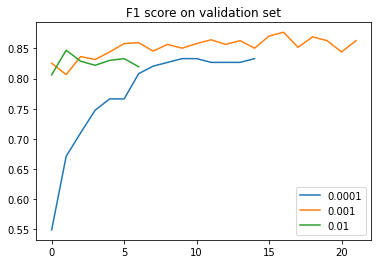

In [18]:
plt.figure()
plt.title('F1 score on validation set')
for lr in learning_rates:
  plt.plot(histories[learning_rates.index(lr)].history["val_custom_f1"], label=lr)
plt.legend()

The best performance on the validation set was reached by the model with lr = 0.001 (on epoch 17).

In [20]:
#load Models

Model4_lr00001 = keras.models.load_model("Model4_lr0.0001", custom_objects={"custom_f1": custom_f1})
Model4_lr0001 = keras.models.load_model("Model4_lr0.001", custom_objects={"custom_f1": custom_f1})
Model4_lr001 = keras.models.load_model("Model4_lr0.01", custom_objects={"custom_f1": custom_f1})

lr =  0.0001
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        82
           1       0.83      0.64      0.72        92

   micro avg       0.74      0.74      0.74       174
   macro avg       0.76      0.75      0.74       174
weighted avg       0.76      0.74      0.74       174
 samples avg       0.74      0.74      0.74       174

lr =  0.001
              precision    recall  f1-score   support

           0       0.81      0.90      0.86        82
           1       0.90      0.82      0.86        92

   micro avg       0.86      0.86      0.86       174
   macro avg       0.86      0.86      0.86       174
weighted avg       0.86      0.86      0.86       174
 samples avg       0.86      0.86      0.86       174

lr =  0.01
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        82
           1       0.88      0.80      0.84        92

   micro avg       0.84      0.84     

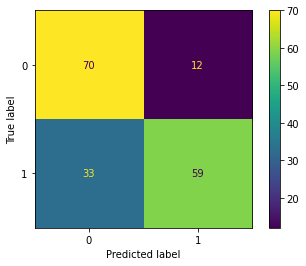

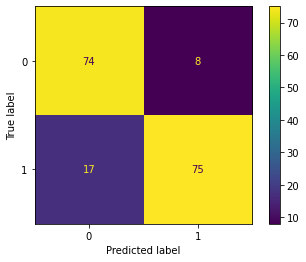

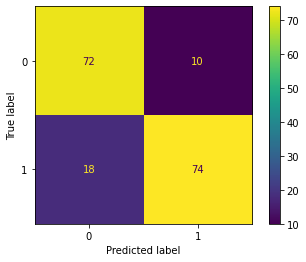

In [21]:
for model in [Model4_lr00001 , Model4_lr0001, Model4_lr001]:
    print('lr = ', learning_rates[[Model4_lr00001 , Model4_lr0001, Model4_lr001].index(model)])
    performance_test(model, X_test[0], y_test[0])

The best performing model on the test set is Model4_lr0.001, both for overall f1-score and for recall on the abnormal class.

### Model 5

In [39]:
from keras.applications.xception import Xception

In [40]:
def build_model5(lr):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    model = Xception(include_top=False, input_tensor = inputs , weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="Model4")
    optimizer = tf.keras.optimizers.Adam(learning_rate= lr)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy" , metrics=[custom_f1]
    )
    return model

In [41]:
lr = 0.001
model5 = build_model5(lr)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
X_train_0, y_train_0 = shuffle(X_train[0], y_train[0]) #training data is ordered by label, it has to be shuffled
history5 = model5.fit(X_train_0, y_train_0, epochs=10, batch_size=32, validation_data=(X_valid[0], y_valid[0]), verbose=2, callbacks=[callback])

In [45]:
model5 = unfreeze_last_layers(model5,lr)

In [ ]:
model5.summary()

In [47]:
history5 = model5.fit(X_train_0, y_train_0, epochs=20, batch_size=32, validation_data=(X_valid[0], y_valid[0]), verbose=2, callbacks=[callback])

Epoch 1/20
44/44 - 4s - loss: 0.3885 - custom_f1: 0.8177 - val_loss: 1.1258 - val_custom_f1: 0.4591
Epoch 2/20
44/44 - 4s - loss: 0.3831 - custom_f1: 0.8359 - val_loss: 987.6679 - val_custom_f1: 0.4437
Epoch 3/20
44/44 - 4s - loss: 0.3685 - custom_f1: 0.8345 - val_loss: 5.8602 - val_custom_f1: 0.8240
Epoch 4/20
44/44 - 4s - loss: 0.3467 - custom_f1: 0.8426 - val_loss: 0.5328 - val_custom_f1: 0.7308
Epoch 5/20
44/44 - 4s - loss: 0.3783 - custom_f1: 0.8246 - val_loss: 0.6942 - val_custom_f1: 0.7558
Epoch 6/20
44/44 - 4s - loss: 0.3199 - custom_f1: 0.8665 - val_loss: 1.1749 - val_custom_f1: 0.6673
Epoch 7/20
44/44 - 4s - loss: 0.3289 - custom_f1: 0.8468 - val_loss: 3.0922 - val_custom_f1: 0.6125
Epoch 8/20
44/44 - 4s - loss: 0.3122 - custom_f1: 0.8622 - val_loss: 0.5273 - val_custom_f1: 0.8269
Epoch 9/20
44/44 - 4s - loss: 0.2742 - custom_f1: 0.8871 - val_loss: 0.7402 - val_custom_f1: 0.7567
Epoch 10/20
44/44 - 4s - loss: 0.2598 - custom_f1: 0.8916 - val_loss: 1.8091 - val_custom_f1: 0.65

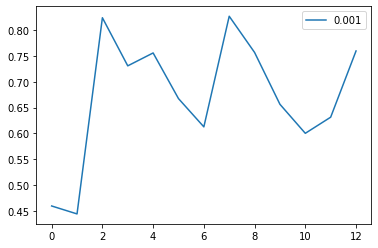

In [49]:
plt.plot(history5.history["val_custom_f1"], label=lr)
plt.legend()

              precision    recall  f1-score   support

           0       0.75      0.94      0.84        82
           1       0.93      0.73      0.82        92

   micro avg       0.83      0.83      0.83       174
   macro avg       0.84      0.83      0.83       174
weighted avg       0.85      0.83      0.83       174
 samples avg       0.83      0.83      0.83       174



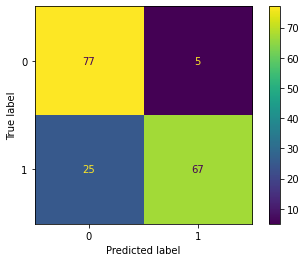

In [50]:
performance_test(model5, X_test[0], y_test[0])

# 3) Cross validation and discussion

The goal of cross validation is to select the most adequate model, trying to reduce bias and statistical variations caused by the way the partition into folds was done.

In [27]:
def cross_validation():
    f1_scores = []
    for i in range(10):
        #The best model on Fold0 is Model3_lr0.0001
        model = tf.keras.models.load_model("../input/models2-3/Model3_lr0.0001", custom_objects={"custom_f1": custom_f1})
        X_train_shuffled, y_train_shuffled = shuffle(X_train[i], y_train[i])
        hist = model.fit(X_train_shuffled, y_train_shuffled, epochs = epochs, batch_size = 32 , validation_data=(X_valid[i], y_valid[i]), verbose=2, callbacks=[callback])
        _, f1_score = model.evaluate(X_test[i], y_test[i])
        f1_scores.append(f1_score)
    return f1_scores

In [ ]:
f1_scores = cross_validation()

In [29]:
f1_scores = np.array(f1_scores)

mean = f1_scores.mean()
std = f1_scores.std() 

In [34]:
print(f'The mean of all f1_scores is {mean:.5f}, with a standard deviation of {std:.5f}')

The mean of all f1_scores is 0.95975, with a standard deviation of 0.02274


For this task is particularly important the recall on the abnormal class since we would like to detect as much abnormal cases as possible, even if it comes at the expense of detecting more false positives (less precision), to start curing the disease as early as possible.
For this reason it could be used a metric that puts more emphasis on recall as the Fb-score, with b>1: this metric gives to recall b times the importance given to precision.
If we want to focus on precision and recall of the abnormal class we could use as metric only the f1-score on the abnormal class: 

def f1_class1(y_true, y_pred): #F1 score for class 1    
f1 = tfa.metrics.F1Score(num_classes=2)  
return f1(y_true, y_pred)[1]  

Another metric that could be useful to monitor is directly the recall on the abnormal class, this would be at the expense of all the other metrics, like precision on the abnormal class and precision and recall on the normal class. Depending by how much we want to avoid missing an abnormal case, we need to choose the right metric to maximize between these ones. 

# 4) Final anaysis

- The dataset came already structured into 10 folds, if we didn’t have the 10 folds ready we could have built them either by hand or using the Kfold() scikit-learn class. The procedure consists of partitioning the dataset into k folds and, for each step of the cross-validation loop, selecting k-2 of them to train the model, 1 of them as validation set during the training and the last 1 as test set.  
When doing this, it's important that each one of the k sets is representative of the entire dataset: the proportion of normal and abnormal cases in each set should be close to the proportion of the entire dataset. We also have to keep in mind that the original dataset order might not be random, so it is good practice to shuffle the dataset before partitioning it. 
If the data set is imbalanced, we could use stratified k-fold cross-validation to create partitions that contain a more equal mix of classes.

- Transfer learning from a pretrained model is a powerful tool. We started from EfficientNetBO, trained on the ImageNet dataset. This dataset contains millions of images, but very different from the fundus images that our task has to deal with. Nevertheless we were able, with not much computational resources nor a big dataset to begin with, to build a model that has a really good performance.
We proceded by steps: first training the classification head of the model, then unfreezing the last layers of the model and only at the end fine-tuning the whole NN. This gave the learning process the ability to concentrate each time on the weights that needed to adapt more to the new task. If we proceeded without training the classification head on the frozen base first, initial epochs may overwrite the useful representations encoded in the pre-trained model.

- It is important to consider that the good results obtained by the model on this dataset do not mean that our model will have such good performance on other datasets of fundus images that the model has not seen during training, obtained with different methods (as seen in [Diaz-Pinto, A., Morales, S., Naranjo, V. et al. CNNs for automatic glaucoma assessment using fundus images: an extensive validation. BioMed Eng OnLine 18, 29 (2019).] https://doi.org/10.1186/s12938-019-0649-y). 
This problem comes from the fact that our model has not only never seen that data but the whole database has different expert labelers and image characteristics. 